In [2]:
# Author: Robert Guthrie

# Les % permettent le reload de modules et participe à l'affichage dans le notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import des librairies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [3]:
'''
Préparation des mots pour l'entrainement
:param seq: mot à convertir en index
:param to_ix: dico avec les index
:return: tensor contenant l'index du mot
'''
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[seq]]
    return torch.tensor(idxs, dtype=torch.long)

'''
Affiche deux graphiques
:param losses_eval: tableau de loss du set d'evaluation/validation du model
:param losses_train: tableau de loss du set d'entrainement du model
'''
def affiche(losses_eval, losses_train):
    plt.plot(np.arange(0,len(losses_eval)),losses_eval)
    plt.title('Evolution loss evaluation set')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(np.arange(0,len(losses_train)),losses_train)
    plt.title('Evolution loss train set')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [4]:
##### Preparation des donnees #####

data_file = open('pos_reference.txt.lima', 'r')
data = []
word_to_ix = {} 
tag_to_ix = {}

for line in data_file : 
    # Pour ne pas prendre les lignes vides
    if not line.isspace():

        # On retire les retours chariots à la fin des lignes + separation du mot et de sa forme morpho-syntaxique dans un tuple
        wordAndToken = line.rstrip('\n').split('\t')

        # Si le mot n'est pas dans le dico on l'ajoute avec son index qui est la taille actuelle du dico
        if wordAndToken[0] not in word_to_ix:
            word_to_ix[wordAndToken[0]] = len(word_to_ix)

        # Pareil pour les tokens
        if wordAndToken[1] not in tag_to_ix:
            tag_to_ix[wordAndToken[1]] = len(tag_to_ix)

        data.append(wordAndToken)

print("Taille des dico : [words : " + str(len(word_to_ix)) + ", tags : " + str(len(tag_to_ix)) + "]")

Taille des dico : [words : 2998, tags : 21]


In [5]:
##### Separation des donnees pour l'entrainement, l'evaluation et le test ######
nb_line = len(data)
line_80 = round((nb_line*80)/100)
line_10 = round((nb_line*10)/100)  

trainSet = data[:line_80]
testSet = data[line_80+1:line_80+line_10]
evalSet = data[line_80+line_10+1:]

trainShape = np.shape(trainSet)
testShape = np.shape(testSet)
evalShape = np.shape(evalSet)

print("Train Set shape : " + str(trainShape))
print("Test Set shape : " + str(testShape))
print("Eval Set shape : " + str(evalShape))

Train Set shape : (8059, 2)
Test Set shape : (1006, 2)
Eval Set shape : (1007, 2)


In [22]:
'''
Fonction d'entrainement pour un model passé en paramètre
:param model: model a entrainer
:param nb_epoch: nombre d'epoque de l'entrainement
:return losses_train & losses_eval: tableaux d'erreurs
'''
def train(model, nb_epoch):

    losses_eval = []
    losses_train = []
    current_loss = 0
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    for epoch in range(nb_epoch):  # again, normally you would NOT do 300 epochs, it is toy data
        print("Epoch : " + str(epoch) +'/'+ str(nb_epoch) + '\n')
        
        #On passe le model en phase d'entrainement
        model.train()
    
        for word, tag in trainSet:

            optimizer.zero_grad()
            
            word_in_train = prepare_sequence(word, word_to_ix)
            target_train = prepare_sequence(tag, tag_to_ix)
           
            tag_scores_train = model(word_in_train)

            loss_train = loss_function(tag_scores_train, target_train)
            current_loss += loss_train.item()

            loss_train.backward()

            optimizer.step()
        
        mean_train_loss = current_loss/len(evalSet)
        losses_train.append(mean_train_loss)
        print('Train Loss after epoch '+ str(epoch) + ': ' + str(mean_train_loss) )
        current_loss = 0.0
        
        optimizer.zero_grad()

        #On passe le model en phase d'evaluation
        model.eval() 
        current_loss = 0.0
        i = 0

        with torch.no_grad():
            for word, tag in evalSet:

                word_in_eval = prepare_sequence(word, word_to_ix)
                target_eval = prepare_sequence(tag, tag_to_ix)

                tag_scores_eval = model(word_in_eval)
                
                loss_eval = loss_function(tag_scores_eval, target_eval)
                current_loss += loss_eval.item()  
                
            mean_eval_loss = current_loss/len(evalSet)
            losses_eval.append(mean_eval_loss)
            print('Evaluation Loss after this epoch '+ str(epoch) + ': ' + str(mean_eval_loss) )
            current_loss = 0.0

    return losses_train, losses_eval



In [23]:
##### Creation du model avec embbeding (mots non pre-entrainne) #####
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
    
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [8]:
# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

################# Train the model #################
model1 = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))


In [9]:
# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(trainSet[0][0], word_to_ix)
    print(inputs)
    tag_scores = model1(inputs)
    print()
    print("=> Scores before training of the tags affected to each word")
    print(tag_scores)

tensor([0])

=> Scores before training of the tags affected to each word
tensor([[-3.1805, -3.2210, -2.7841, -2.5930, -2.9945, -3.4355, -2.9467, -3.1316,
         -2.9867, -3.2735, -3.2981, -2.9846, -3.2573, -3.1078, -3.4080, -2.7191,
         -2.9285, -3.0331, -2.7619, -3.1494, -3.2764]])


In [10]:
loss_train, loss_eval = train(model1, 2)

Epoch : 0/2

Train Loss after this epoch : 13.01841297410632
Evaluation Loss after this epoch : 1.6074834223503716
Epoch : 1/2

Train Loss after this epoch : 10.066778687141047
Evaluation Loss after this epoch : 1.4085364826892937


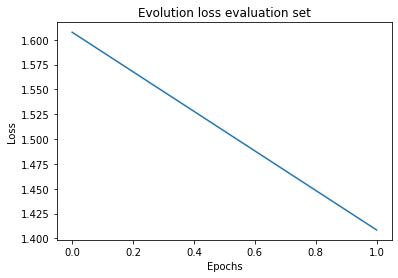

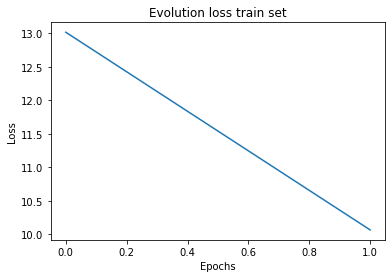

In [11]:
affiche(loss_eval, loss_train)

In [24]:
# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(trainSet[4][0], word_to_ix)
    print()
    print('=> The sentence to analyze (first sentence of the Training data):')
    print(trainSet[4])

    print()
    print("=> Training data: each word is assigned to a unique index:")
    tag_scores = model1(inputs)

    print()
    print("=> Scores after training of the tags affected to each word of the sentence to analyze:")
    print(tag_scores)


=> The sentence to analyze (first sentence of the Training data):
['will', 'AUX']

=> Training data: each word is assigned to a unique index:

=> Scores after training of the tags affected to each word of the sentence to analyze:
tensor([[-2.4936, -9.5667, -2.9792, -2.0443, -2.3676, -5.9257, -0.9950, -3.4135,
         -5.3702, -5.3768, -2.9823, -9.8843, -3.9294, -8.5204, -2.0801, -3.7683,
         -6.5268, -4.9826, -8.0326, -6.9256, -7.6386]])


In [14]:
##### Creation du model avec embbeding (mots pre-entrainne avec Glove) #####

class LSTMTaggerGLove(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, weight):
        super(LSTMTaggerGLove, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.load_state_dict({'weight': weight}) #de taille vocab_size, donc marche pas

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [15]:
#Chargement des donnees de GloVe
emmbed_dict = {}
embedding_dim = 50
path = '../../../glove.6B.50d.txt' #mettre le path des mots de Glove
with open(path,'r', encoding = "UTF-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector
      

In [16]:
print(emmbed_dict['will'])

[ 8.1544e-01  3.0171e-01  5.4720e-01  4.6581e-01  2.8531e-01 -5.6112e-01
 -4.3913e-01 -9.0877e-03  1.0002e-01 -1.7218e-01  2.8133e-01  3.7672e-01
 -4.0756e-01  1.5836e-01  8.9113e-01  1.2997e+00  5.1508e-01 -1.9480e-01
  5.1856e-02 -9.3380e-01  6.9955e-02 -2.4876e-01 -1.6723e-02 -2.0310e-01
 -3.3558e-02 -1.8132e+00  1.1199e-01 -3.1961e-01 -1.3746e-01 -4.5499e-01
  3.8856e+00  1.2140e+00 -1.0046e+00 -5.6274e-02  3.8776e-03 -4.0669e-01
  2.9452e-01  3.0171e-01  3.8848e-02 -5.6088e-01 -4.6582e-01  1.7155e-01
  3.3729e-01 -1.5247e-01  2.3771e-02  5.1415e-01 -2.1759e-01  3.1965e-01
 -3.4741e-01  4.1672e-01]


In [17]:
#Création et remplissage de la matrice des poids
'''
Pour chaque mot du vocabulaire de l’ensemble de données, nous vérifions s’il est sur le vocabulaire de GloVe. 
S’il le fait, nous chargeons son vecteur de mots pré-entraîné. 
Sinon, nous initialisons un vecteur aléatoire.
'''

matrix_len = len(word_to_ix)
print(matrix_len)
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

for i, word in enumerate(word_to_ix):
    try: 
        weights_matrix[i] = emmbed_dict[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

#Conversion en tensor pour l'embedding
weight = torch.FloatTensor(weights_matrix)

print(words_found)

2998
2064


In [18]:
# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 50
HIDDEN_DIM = 6

################# Train the model #################
model2 = LSTMTaggerGLove(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix), weight)

In [19]:
# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(trainSet[0][0], word_to_ix)
    print(inputs)
    tag_scores = model2(inputs)
    print()
    print("=> Scores before training of the tags affected to each word")
    print(tag_scores)

tensor([0])

=> Scores before training of the tags affected to each word
tensor([[-2.6911, -3.3250, -3.0271, -3.2098, -3.1947, -3.3892, -2.9183, -3.3535,
         -3.1824, -3.3457, -3.1321, -2.7133, -2.6930, -3.3133, -3.3835, -3.3711,
         -2.9236, -2.6939, -2.6650, -2.8308, -3.3591]])


In [20]:
loss_train, loss_eval = train(model2, 10)

Epoch : 0/10

Train Loss after this epoch : 9.172121341676657
Evaluation Loss after this epoch : 1.1078281019677434
Epoch : 1/10

Train Loss after this epoch : 5.262649531798914
Evaluation Loss after this epoch : 0.965536994251257
Epoch : 2/10

Train Loss after this epoch : 3.78000620625074
Evaluation Loss after this epoch : 1.090249083004227
Epoch : 3/10

Train Loss after this epoch : 2.974239101921238
Evaluation Loss after this epoch : 0.9980494425289403
Epoch : 4/10

Train Loss after this epoch : 2.2010052786433687
Evaluation Loss after this epoch : 1.039895201835145
Epoch : 5/10

Train Loss after this epoch : 1.8294197718889604
Evaluation Loss after this epoch : 1.0813744479300724
Epoch : 6/10

Train Loss after this epoch : 1.4939100162789436
Evaluation Loss after this epoch : 1.180394617663785
Epoch : 7/10

Train Loss after this epoch : 1.2906010896073228
Evaluation Loss after this epoch : 1.2564468010234895
Epoch : 8/10

Train Loss after this epoch : 1.1662424316430506
Evaluation

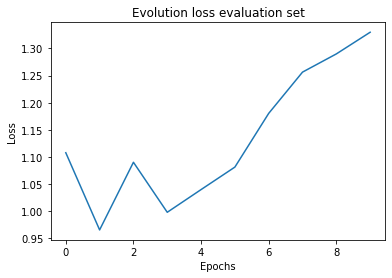

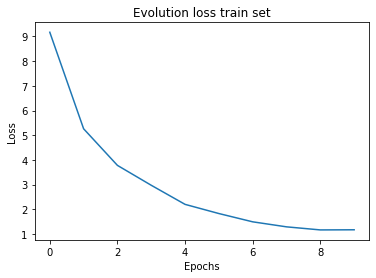

In [21]:
affiche(loss_eval, loss_train)